In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset 
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import torch.optim as optim
import math
import itertools
from IPython import display

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
realimages = torchvision.datasets.MNIST(root='./data', train=True,download=True, transform=transform)
train_loader= torch.utils.data.DataLoader(realimages, batch_size=100,shuffle=True, num_workers=2)

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        n_featues = 28*28
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_featues, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )
    def forward(self,x):
        x = x.view(x.size(0),784)
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x.view(x.size(0),-1)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        input_feature = 100
        out_feature =28*28
        
        self.hidden0 = nn.Sequential(
            nn.Linear(input_feature, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, out_feature),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0),100)
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x


In [5]:
discriminator = Discriminator().cuda()
generator = Generator().cuda()

In [6]:
criterion = nn.BCELoss()
lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

In [7]:
def train_discriminator(discriminator, images, real_labels, fake_images, fake_labels):
    discriminator.zero_grad()
    outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels)
    real_score = outputs
    
    outputs = discriminator(fake_images) 
    fake_loss = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score

In [8]:
def train_generator(generator, discriminator_outputs, real_labels):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels)
    g_loss.backward()
    g_optimizer.step()
    return g_loss

In [9]:
# draw samples from the input distribution to inspect the generation on training 
num_test_samples = 100
test_noise = Variable(torch.randn(num_test_samples, 100).cuda())

/home/infero/.local/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/infero/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/200], Step[100/600], d_loss: 1.2104, g_loss: 1.1464, D(x): 0.68, D(G(z)): 0.49
Epoch [1/200], Step[200/600], d_loss: 1.4077, g_loss: 3.1764, D(x): 0.66, D(G(z)): 0.35
Epoch [1/200], Step[300/600], d_loss: 1.9734, g_loss: 0.8952, D(x): 0.55, D(G(z)): 0.52
Epoch [1/200], Step[400/600], d_loss: 0.5812, g_loss: 2.1910, D(x): 0.82, D(G(z)): 0.25
Epoch [1/200], Step[500/600], d_loss: 0.7777, g_loss: 1.5949, D(x): 0.74, D(G(z)): 0.34
Epoch [1/200], Step[600/600], d_loss: 0.5155, g_loss: 3.0901, D(x): 0.81, D(G(z)): 0.18
Epoch [2/200], Step[100/600], d_loss: 1.1628, g_loss: 3.4706, D(x): 0.61, D(G(z)): 0.26
Epoch [2/200], Step[200/600], d_loss: 1.9817, g_loss: 0.4784, D(x): 0.61, D(G(z)): 0.69
Epoch [2/200], Step[300/600], d_loss: 1.2448, g_loss: 1.3572, D(x): 0.65, D(G(z)): 0.46
Epoch [2/200], Step[400/600], d_loss: 0.7418, g_loss: 1.9595, D(x): 0.80, D(G(z)): 0.33
Epoch [2/200], Step[500/600], d_loss: 1.7788, g_loss: 0.9963, D(x): 0.62, D(G(z)): 0.53
Epoch [2/200], Step[600/600], d_

Epoch [16/200], Step[400/600], d_loss: 0.9178, g_loss: 1.7481, D(x): 0.79, D(G(z)): 0.37
Epoch [16/200], Step[500/600], d_loss: 0.6615, g_loss: 1.9262, D(x): 0.78, D(G(z)): 0.25
Epoch [16/200], Step[600/600], d_loss: 0.8621, g_loss: 1.5499, D(x): 0.70, D(G(z)): 0.31
Epoch [17/200], Step[100/600], d_loss: 0.9462, g_loss: 1.3378, D(x): 0.68, D(G(z)): 0.29
Epoch [17/200], Step[200/600], d_loss: 0.8858, g_loss: 1.5619, D(x): 0.63, D(G(z)): 0.23
Epoch [17/200], Step[300/600], d_loss: 1.0267, g_loss: 1.4507, D(x): 0.72, D(G(z)): 0.34
Epoch [17/200], Step[400/600], d_loss: 0.8778, g_loss: 1.4984, D(x): 0.71, D(G(z)): 0.30
Epoch [17/200], Step[500/600], d_loss: 1.0474, g_loss: 1.2922, D(x): 0.72, D(G(z)): 0.38
Epoch [17/200], Step[600/600], d_loss: 0.8491, g_loss: 1.6442, D(x): 0.72, D(G(z)): 0.26
Epoch [18/200], Step[100/600], d_loss: 0.8769, g_loss: 1.6220, D(x): 0.68, D(G(z)): 0.27
Epoch [18/200], Step[200/600], d_loss: 0.7998, g_loss: 1.2803, D(x): 0.72, D(G(z)): 0.32
Epoch [18/200], Step[

Epoch [32/200], Step[100/600], d_loss: 0.9334, g_loss: 1.3155, D(x): 0.67, D(G(z)): 0.32
Epoch [32/200], Step[200/600], d_loss: 1.0660, g_loss: 1.3116, D(x): 0.70, D(G(z)): 0.39
Epoch [32/200], Step[300/600], d_loss: 1.0836, g_loss: 1.0439, D(x): 0.71, D(G(z)): 0.44
Epoch [32/200], Step[400/600], d_loss: 1.2139, g_loss: 1.4553, D(x): 0.62, D(G(z)): 0.38
Epoch [32/200], Step[500/600], d_loss: 1.1491, g_loss: 1.3746, D(x): 0.57, D(G(z)): 0.33
Epoch [32/200], Step[600/600], d_loss: 1.0007, g_loss: 1.0255, D(x): 0.67, D(G(z)): 0.39
Epoch [33/200], Step[100/600], d_loss: 0.9179, g_loss: 1.2472, D(x): 0.68, D(G(z)): 0.34
Epoch [33/200], Step[200/600], d_loss: 0.9760, g_loss: 1.3702, D(x): 0.65, D(G(z)): 0.31
Epoch [33/200], Step[300/600], d_loss: 1.0512, g_loss: 1.1424, D(x): 0.65, D(G(z)): 0.36
Epoch [33/200], Step[400/600], d_loss: 0.8824, g_loss: 1.4462, D(x): 0.68, D(G(z)): 0.32
Epoch [33/200], Step[500/600], d_loss: 0.8364, g_loss: 1.4062, D(x): 0.72, D(G(z)): 0.33
Epoch [33/200], Step[

Epoch [47/200], Step[400/600], d_loss: 1.3188, g_loss: 0.9440, D(x): 0.58, D(G(z)): 0.47
Epoch [47/200], Step[500/600], d_loss: 1.2080, g_loss: 0.9299, D(x): 0.65, D(G(z)): 0.48
Epoch [47/200], Step[600/600], d_loss: 1.2158, g_loss: 1.0012, D(x): 0.62, D(G(z)): 0.44
Epoch [48/200], Step[100/600], d_loss: 1.0058, g_loss: 1.3446, D(x): 0.66, D(G(z)): 0.37
Epoch [48/200], Step[200/600], d_loss: 0.9754, g_loss: 1.1156, D(x): 0.67, D(G(z)): 0.37
Epoch [48/200], Step[300/600], d_loss: 0.9750, g_loss: 1.2833, D(x): 0.66, D(G(z)): 0.35
Epoch [48/200], Step[400/600], d_loss: 1.1799, g_loss: 1.0843, D(x): 0.64, D(G(z)): 0.44
Epoch [48/200], Step[500/600], d_loss: 1.2953, g_loss: 1.1735, D(x): 0.53, D(G(z)): 0.40
Epoch [48/200], Step[600/600], d_loss: 1.2203, g_loss: 0.9417, D(x): 0.58, D(G(z)): 0.42
Epoch [49/200], Step[100/600], d_loss: 1.2546, g_loss: 0.8903, D(x): 0.58, D(G(z)): 0.43
Epoch [49/200], Step[200/600], d_loss: 1.2329, g_loss: 1.1086, D(x): 0.58, D(G(z)): 0.41
Epoch [49/200], Step[

Epoch [63/200], Step[100/600], d_loss: 1.3021, g_loss: 1.0608, D(x): 0.53, D(G(z)): 0.38
Epoch [63/200], Step[200/600], d_loss: 1.0726, g_loss: 1.1883, D(x): 0.65, D(G(z)): 0.39
Epoch [63/200], Step[300/600], d_loss: 1.1581, g_loss: 1.1516, D(x): 0.67, D(G(z)): 0.45
Epoch [63/200], Step[400/600], d_loss: 1.0831, g_loss: 1.0572, D(x): 0.62, D(G(z)): 0.40
Epoch [63/200], Step[500/600], d_loss: 1.1360, g_loss: 0.9372, D(x): 0.62, D(G(z)): 0.42
Epoch [63/200], Step[600/600], d_loss: 1.3309, g_loss: 0.7882, D(x): 0.58, D(G(z)): 0.48
Epoch [64/200], Step[100/600], d_loss: 1.2799, g_loss: 0.8936, D(x): 0.55, D(G(z)): 0.44
Epoch [64/200], Step[200/600], d_loss: 1.1470, g_loss: 1.2398, D(x): 0.55, D(G(z)): 0.36
Epoch [64/200], Step[300/600], d_loss: 1.0889, g_loss: 1.1479, D(x): 0.60, D(G(z)): 0.38
Epoch [64/200], Step[400/600], d_loss: 1.1499, g_loss: 1.0369, D(x): 0.59, D(G(z)): 0.40
Epoch [64/200], Step[500/600], d_loss: 1.1856, g_loss: 1.0080, D(x): 0.58, D(G(z)): 0.42
Epoch [64/200], Step[

Epoch [78/200], Step[400/600], d_loss: 1.3506, g_loss: 0.9653, D(x): 0.53, D(G(z)): 0.41
Epoch [78/200], Step[500/600], d_loss: 1.3796, g_loss: 1.0125, D(x): 0.49, D(G(z)): 0.41
Epoch [78/200], Step[600/600], d_loss: 1.3151, g_loss: 0.7985, D(x): 0.55, D(G(z)): 0.46
Epoch [79/200], Step[100/600], d_loss: 1.3307, g_loss: 1.1493, D(x): 0.63, D(G(z)): 0.48
Epoch [79/200], Step[200/600], d_loss: 1.1482, g_loss: 0.9758, D(x): 0.59, D(G(z)): 0.41
Epoch [79/200], Step[300/600], d_loss: 1.1854, g_loss: 0.9635, D(x): 0.55, D(G(z)): 0.41
Epoch [79/200], Step[400/600], d_loss: 1.3134, g_loss: 1.0602, D(x): 0.53, D(G(z)): 0.42
Epoch [79/200], Step[500/600], d_loss: 1.2865, g_loss: 0.8908, D(x): 0.60, D(G(z)): 0.49
Epoch [79/200], Step[600/600], d_loss: 1.1057, g_loss: 1.0751, D(x): 0.64, D(G(z)): 0.40
Epoch [80/200], Step[100/600], d_loss: 1.2157, g_loss: 1.0475, D(x): 0.62, D(G(z)): 0.45
Epoch [80/200], Step[200/600], d_loss: 1.2000, g_loss: 1.1724, D(x): 0.51, D(G(z)): 0.35
Epoch [80/200], Step[

Epoch [94/200], Step[100/600], d_loss: 1.1753, g_loss: 1.0795, D(x): 0.59, D(G(z)): 0.37
Epoch [94/200], Step[200/600], d_loss: 1.3406, g_loss: 1.0489, D(x): 0.58, D(G(z)): 0.44
Epoch [94/200], Step[300/600], d_loss: 1.1378, g_loss: 1.1419, D(x): 0.56, D(G(z)): 0.36
Epoch [94/200], Step[400/600], d_loss: 1.1647, g_loss: 1.0578, D(x): 0.57, D(G(z)): 0.39
Epoch [94/200], Step[500/600], d_loss: 1.1831, g_loss: 1.0165, D(x): 0.56, D(G(z)): 0.40
Epoch [94/200], Step[600/600], d_loss: 1.1966, g_loss: 1.0170, D(x): 0.56, D(G(z)): 0.39
Epoch [95/200], Step[100/600], d_loss: 1.0716, g_loss: 1.0703, D(x): 0.60, D(G(z)): 0.37
Epoch [95/200], Step[200/600], d_loss: 1.1765, g_loss: 1.0122, D(x): 0.58, D(G(z)): 0.42
Epoch [95/200], Step[300/600], d_loss: 1.2483, g_loss: 0.8442, D(x): 0.60, D(G(z)): 0.46
Epoch [95/200], Step[400/600], d_loss: 1.2387, g_loss: 0.9959, D(x): 0.58, D(G(z)): 0.43
Epoch [95/200], Step[500/600], d_loss: 1.3315, g_loss: 0.9043, D(x): 0.54, D(G(z)): 0.44
Epoch [95/200], Step[

Epoch [109/200], Step[300/600], d_loss: 1.3077, g_loss: 0.8574, D(x): 0.57, D(G(z)): 0.47
Epoch [109/200], Step[400/600], d_loss: 1.2881, g_loss: 0.8090, D(x): 0.56, D(G(z)): 0.47
Epoch [109/200], Step[500/600], d_loss: 1.2469, g_loss: 1.0316, D(x): 0.51, D(G(z)): 0.36
Epoch [109/200], Step[600/600], d_loss: 1.2596, g_loss: 0.9379, D(x): 0.54, D(G(z)): 0.41
Epoch [110/200], Step[100/600], d_loss: 1.2622, g_loss: 0.8791, D(x): 0.54, D(G(z)): 0.43
Epoch [110/200], Step[200/600], d_loss: 1.3514, g_loss: 0.8595, D(x): 0.58, D(G(z)): 0.48
Epoch [110/200], Step[300/600], d_loss: 1.2065, g_loss: 1.0064, D(x): 0.57, D(G(z)): 0.42
Epoch [110/200], Step[400/600], d_loss: 1.2547, g_loss: 0.8255, D(x): 0.63, D(G(z)): 0.50
Epoch [110/200], Step[500/600], d_loss: 1.2489, g_loss: 0.8330, D(x): 0.60, D(G(z)): 0.48
Epoch [110/200], Step[600/600], d_loss: 1.2866, g_loss: 0.8621, D(x): 0.53, D(G(z)): 0.44
Epoch [111/200], Step[100/600], d_loss: 1.2321, g_loss: 0.8457, D(x): 0.59, D(G(z)): 0.45
Epoch [111

Epoch [124/200], Step[500/600], d_loss: 1.2382, g_loss: 0.8734, D(x): 0.55, D(G(z)): 0.43
Epoch [124/200], Step[600/600], d_loss: 1.2460, g_loss: 0.8703, D(x): 0.58, D(G(z)): 0.45
Epoch [125/200], Step[100/600], d_loss: 1.3389, g_loss: 0.7981, D(x): 0.56, D(G(z)): 0.49
Epoch [125/200], Step[200/600], d_loss: 1.2443, g_loss: 0.9284, D(x): 0.57, D(G(z)): 0.46
Epoch [125/200], Step[300/600], d_loss: 1.2223, g_loss: 0.8445, D(x): 0.57, D(G(z)): 0.44
Epoch [125/200], Step[400/600], d_loss: 1.3058, g_loss: 0.9120, D(x): 0.49, D(G(z)): 0.42
Epoch [125/200], Step[500/600], d_loss: 1.3458, g_loss: 0.9348, D(x): 0.53, D(G(z)): 0.46
Epoch [125/200], Step[600/600], d_loss: 1.2684, g_loss: 1.0898, D(x): 0.59, D(G(z)): 0.44
Epoch [126/200], Step[100/600], d_loss: 1.1450, g_loss: 0.8597, D(x): 0.60, D(G(z)): 0.42
Epoch [126/200], Step[200/600], d_loss: 1.2374, g_loss: 0.9366, D(x): 0.59, D(G(z)): 0.45
Epoch [126/200], Step[300/600], d_loss: 1.3361, g_loss: 0.9280, D(x): 0.53, D(G(z)): 0.44
Epoch [126

Epoch [140/200], Step[100/600], d_loss: 1.2930, g_loss: 0.7966, D(x): 0.54, D(G(z)): 0.43
Epoch [140/200], Step[200/600], d_loss: 1.3274, g_loss: 0.8717, D(x): 0.55, D(G(z)): 0.46
Epoch [140/200], Step[300/600], d_loss: 1.2967, g_loss: 0.8389, D(x): 0.55, D(G(z)): 0.45
Epoch [140/200], Step[400/600], d_loss: 1.2815, g_loss: 0.8747, D(x): 0.56, D(G(z)): 0.45
Epoch [140/200], Step[500/600], d_loss: 1.3098, g_loss: 0.8591, D(x): 0.56, D(G(z)): 0.44
Epoch [140/200], Step[600/600], d_loss: 1.2025, g_loss: 0.9288, D(x): 0.58, D(G(z)): 0.43
Epoch [141/200], Step[100/600], d_loss: 1.2058, g_loss: 1.0561, D(x): 0.54, D(G(z)): 0.40
Epoch [141/200], Step[200/600], d_loss: 1.3557, g_loss: 0.8005, D(x): 0.53, D(G(z)): 0.45
Epoch [141/200], Step[300/600], d_loss: 1.4266, g_loss: 1.0913, D(x): 0.47, D(G(z)): 0.39
Epoch [141/200], Step[400/600], d_loss: 1.3136, g_loss: 0.7822, D(x): 0.57, D(G(z)): 0.48
Epoch [141/200], Step[500/600], d_loss: 1.2789, g_loss: 0.9214, D(x): 0.56, D(G(z)): 0.45
Epoch [141

Epoch [155/200], Step[300/600], d_loss: 1.2023, g_loss: 0.9335, D(x): 0.58, D(G(z)): 0.41
Epoch [155/200], Step[400/600], d_loss: 1.1524, g_loss: 0.9533, D(x): 0.62, D(G(z)): 0.42
Epoch [155/200], Step[500/600], d_loss: 1.2946, g_loss: 0.9352, D(x): 0.55, D(G(z)): 0.43
Epoch [155/200], Step[600/600], d_loss: 1.2352, g_loss: 0.8101, D(x): 0.54, D(G(z)): 0.43
Epoch [156/200], Step[100/600], d_loss: 1.3060, g_loss: 0.8806, D(x): 0.53, D(G(z)): 0.45
Epoch [156/200], Step[200/600], d_loss: 1.2485, g_loss: 0.7750, D(x): 0.60, D(G(z)): 0.48
Epoch [156/200], Step[300/600], d_loss: 1.2435, g_loss: 0.8957, D(x): 0.54, D(G(z)): 0.43
Epoch [156/200], Step[400/600], d_loss: 1.2034, g_loss: 0.9437, D(x): 0.59, D(G(z)): 0.42
Epoch [156/200], Step[500/600], d_loss: 1.4338, g_loss: 0.8448, D(x): 0.53, D(G(z)): 0.49
Epoch [156/200], Step[600/600], d_loss: 1.3149, g_loss: 0.9473, D(x): 0.58, D(G(z)): 0.48
Epoch [157/200], Step[100/600], d_loss: 1.2709, g_loss: 0.8448, D(x): 0.51, D(G(z)): 0.41
Epoch [157

Epoch [170/200], Step[500/600], d_loss: 1.2541, g_loss: 0.9328, D(x): 0.55, D(G(z)): 0.44
Epoch [170/200], Step[600/600], d_loss: 1.1316, g_loss: 0.9758, D(x): 0.58, D(G(z)): 0.40
Epoch [171/200], Step[100/600], d_loss: 1.1496, g_loss: 1.0423, D(x): 0.57, D(G(z)): 0.40
Epoch [171/200], Step[200/600], d_loss: 1.1908, g_loss: 1.0151, D(x): 0.56, D(G(z)): 0.40
Epoch [171/200], Step[300/600], d_loss: 1.2211, g_loss: 0.8876, D(x): 0.54, D(G(z)): 0.42
Epoch [171/200], Step[400/600], d_loss: 1.1776, g_loss: 0.9095, D(x): 0.57, D(G(z)): 0.41
Epoch [171/200], Step[500/600], d_loss: 1.2378, g_loss: 0.8657, D(x): 0.55, D(G(z)): 0.43
Epoch [171/200], Step[600/600], d_loss: 1.2480, g_loss: 0.8336, D(x): 0.56, D(G(z)): 0.44
Epoch [172/200], Step[100/600], d_loss: 1.2965, g_loss: 0.9026, D(x): 0.53, D(G(z)): 0.44
Epoch [172/200], Step[200/600], d_loss: 1.2768, g_loss: 0.9765, D(x): 0.55, D(G(z)): 0.44
Epoch [172/200], Step[300/600], d_loss: 1.2190, g_loss: 0.9643, D(x): 0.60, D(G(z)): 0.46
Epoch [172

Epoch [186/200], Step[100/600], d_loss: 1.2911, g_loss: 0.8577, D(x): 0.52, D(G(z)): 0.43
Epoch [186/200], Step[200/600], d_loss: 1.2260, g_loss: 0.9089, D(x): 0.56, D(G(z)): 0.42
Epoch [186/200], Step[300/600], d_loss: 1.1693, g_loss: 0.9027, D(x): 0.57, D(G(z)): 0.39
Epoch [186/200], Step[400/600], d_loss: 1.1760, g_loss: 0.8771, D(x): 0.59, D(G(z)): 0.42
Epoch [186/200], Step[500/600], d_loss: 1.2672, g_loss: 1.0071, D(x): 0.51, D(G(z)): 0.40
Epoch [186/200], Step[600/600], d_loss: 1.3166, g_loss: 0.8316, D(x): 0.57, D(G(z)): 0.48
Epoch [187/200], Step[100/600], d_loss: 1.2763, g_loss: 1.0049, D(x): 0.54, D(G(z)): 0.43
Epoch [187/200], Step[200/600], d_loss: 1.2177, g_loss: 0.9149, D(x): 0.57, D(G(z)): 0.44
Epoch [187/200], Step[300/600], d_loss: 1.1766, g_loss: 0.8724, D(x): 0.61, D(G(z)): 0.45
Epoch [187/200], Step[400/600], d_loss: 1.3638, g_loss: 0.8029, D(x): 0.57, D(G(z)): 0.48
Epoch [187/200], Step[500/600], d_loss: 1.2971, g_loss: 0.8158, D(x): 0.55, D(G(z)): 0.46
Epoch [187

AttributeError: 'Figure' object has no attribute 'close'

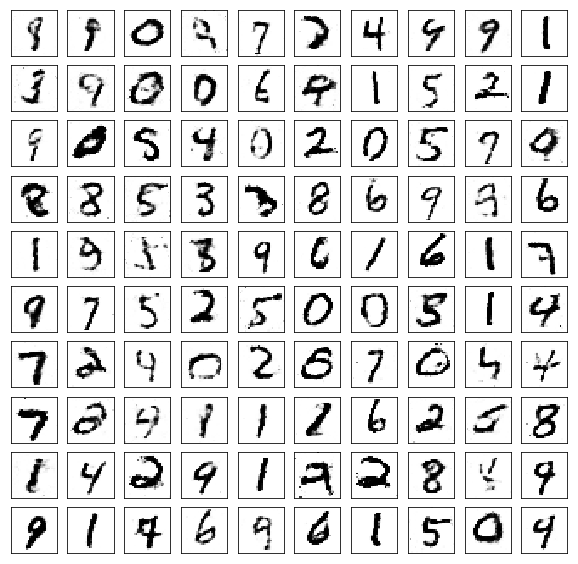

In [11]:


# create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(10, 10))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

# set number of epochs and initialize figure counter
num_epochs = 200
num_batches = len(train_loader)
num_fig = 0


for epoch in range(num_epochs):
    for n, (images, _) in enumerate(train_loader):
        images = Variable(images.cuda())
        real_labels = Variable(torch.ones(images.size(0)).cuda())
        
        # Sample from generator
        noise = Variable(torch.randn(images.size(0), 100).cuda())
        fake_images = generator(noise)
        fake_labels = Variable(torch.zeros(images.size(0)).cuda())
        
        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(discriminator, images, real_labels, fake_images, fake_labels)
        
        # Sample again from the generator and get output from discriminator
        noise = Variable(torch.randn(images.size(0), 100).cuda())
        fake_images = generator(noise)
        outputs = discriminator(fake_images)

        # Train the generator
        g_loss = train_generator(generator, outputs, real_labels)
        
        if (n+1) % 100 == 0:
            test_images = generator(test_noise)
            #print(test_images.shape)
            
            for k in range(num_test_samples):
                i = k//10
                j = k%10
                ax[i,j].cla()
                ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
            plt.savefig('./samples/VGAN/image.png')
            num_fig += 1
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, ' 
                  'D(x): %.2f, D(G(z)): %.2f' 
                  %(epoch + 1, num_epochs, n+1, num_batches, d_loss.data[0], g_loss.data[0],
                    real_score.data.mean(), fake_score.data.mean()))

fig.close()